In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import scipy.stats.distributions as dist
import urllib
from PIL import Image

In [ ]:
os.chdir('../')

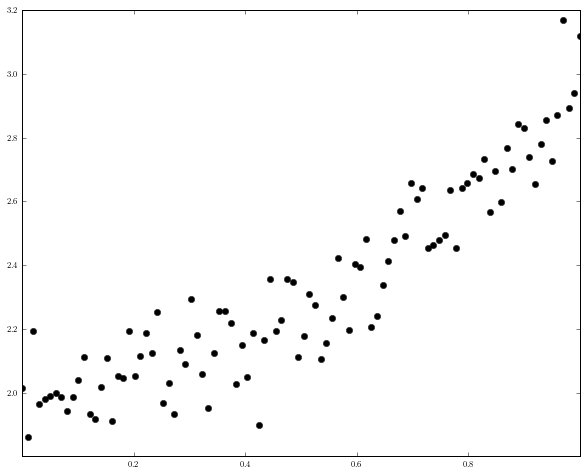

In [107]:
x = np.linspace(0,1,100)

y = x**2 +2
y_noise = np.random.randn(100)*0.1
y = y+y_noise

z = x**1.5 + 1
z_noise = np.random.randn(100)*0.1
z = z+z_noise

_ = plt.plot(x,y,'ko')

In [185]:
from astroML.linear_model import NadarayaWatson

clf = NadarayaWatson('gaussian',h=0.1)
clf.fit(x[:, None], y)
xg = np.linspace(0,1,1000)
y_fit = clf.predict(xg[:, None])
#mu_fit = clf.predict(z[:, None])

In [186]:
xy = np.array([x,y]).T

In [195]:
clf = NadarayaWatson('gaussian',h=0.1)
clf.fit(xy, z)
xg = np.array([np.linspace(0,1,1000),np.linspace(0,5,1000)]).T
xy_fit = clf.predict(xg)

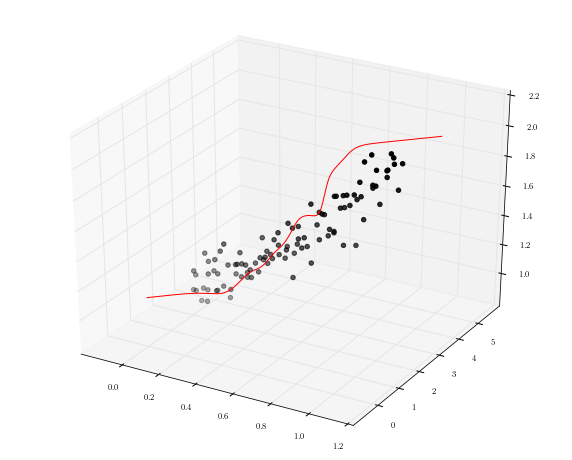

In [196]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z,c='k')
ax.plot(xg[:,0],xg[:,1],xy_fit,color='r')

In [197]:
fit_results = Table.read('../output_files/t11_arms_number/a36_more_than_4/fit_results.fits')

In [229]:
from sklearn.preprocessing import scale
from sklearn.cross_validation import KFold

In [435]:
os.chdir('../')

In [437]:
full_data = Table.read('../../fits/full_sample_debiased.fits')
import make_dictionaries
questions = make_dictionaries.questions

In [409]:
x_raw = fit_results['Mr']
y_raw = fit_results['R50']
z_raw = fit_results['redshift']

k = fit_results['k']
c = fit_results['c']

x = scale(x_raw)
y = scale(y_raw)
z = scale(z_raw)
xyz = np.array([x,y,z]).T

In [410]:
def kernel_4d(x,y,z,k,h_arr=np.linspace(0.1,1,100)):
    
    x = scale(x)
    y = scale(y)
    z = scale(z)
    xyz = np.array([x,y,z]).T
    
    kf = KFold(n=len(x),n_folds=5,shuffle=True)
    
    residuals = []
    
    for h in h_arr:
        
        residual = []
    
        for train,test in kf:
    
            training_xyz = xyz[train]
            training_k = k[train]
            test_xyz = xyz[test]
            test_k = k[test]
    
            clf = NadarayaWatson('gaussian',h=h)
            clf.fit(training_xyz, training_k)
            k_fit = clf.predict(test_xyz)
            
            residual.append(np.sum((test_k - k_fit)**2))
        
        residuals.append(np.sum(residual))

    return residuals,h_arr

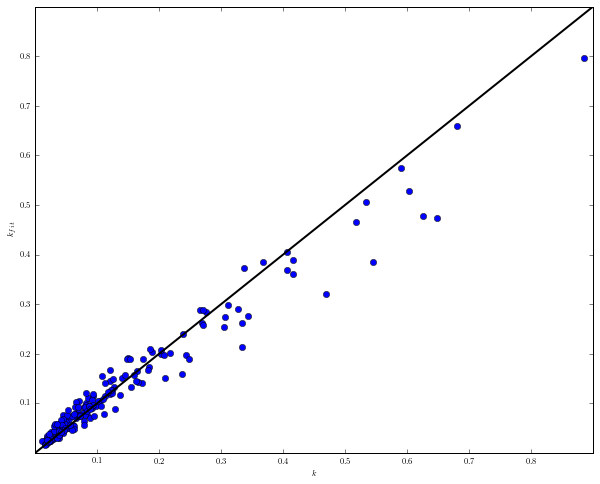

In [411]:
residuals,h_array = kernel_4d(x,y,z,k)
best_h_k = h_array[np.argmin(residuals)]

clf = NadarayaWatson('gaussian',h=best_h)
k_clf = clf.fit(xyz,k)
k_fit = clf.predict(xyz)
plt.plot(k,k_fit,'bo')

xlims = plt.gca().get_xlim()
plt.plot([xlims[0],xlims[1]],[xlims[0],xlims[1]],'k-',linewidth=2)

plt.xlabel('$k$')
plt.ylabel('$k_{fit}$')

In [463]:
c.shape

(211,)

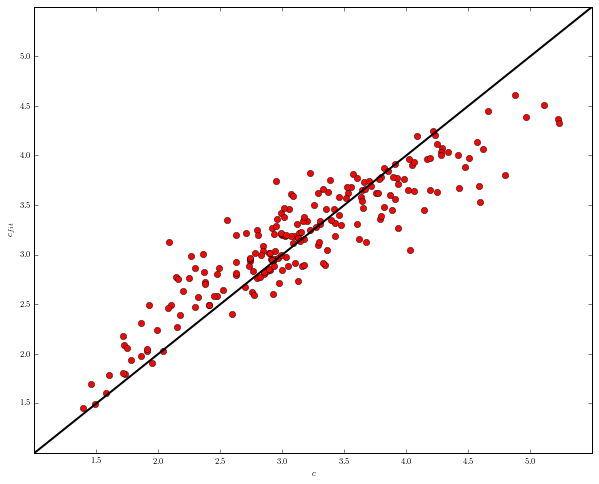

In [412]:
residuals,h_array = kernel_4d(x,y,z,c)
best_h_c = h_array[np.argmin(residuals)]

clf = NadarayaWatson('gaussian',h=best_h)
c_clf = clf.fit(xyz,c)
c_fit = clf.predict(xyz)
plt.plot(c,c_fit,'ro')

xlims = plt.gca().get_xlim()
plt.plot([xlims[0],xlims[1]],[xlims[0],xlims[1]],'k-',linewidth=2)

plt.xlabel('$c$')
plt.ylabel('$c_{fit}$')

NameError: name 'make_dictionaries' is not defined

In [296]:
in_volume_limit = full_data['in_volume_limit'] == True

in_spirals = (full_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']*
              full_data['t02_edgeon_a05_no_debiased_rh']*
              full_data['t04_spiral_a08_spiral_debiased_rh']) > 0.5

in_N = full_data['t04_spiral_a08_spiral_count'] - full_data['t11_arms_number_a37_cant_tell_count'] >= 5

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


In [297]:
spirals = full_data[(in_volume_limit) & (in_spirals) & (in_N)]

In [466]:
def get_NW_fit(x,y,z,k):
    
    residuals,h_array = get_kernel(x,y,z,k)
    best_h_k = h_array[np.argmin(residuals)]
    clf = NadarayaWatson('gaussian',h=best_h)
    k_clf = clf.fit(xyz,k)
    
    return k_clf


def get_kernel(x,y,z,k,h_arr=np.linspace(0.1,1,100)):

    xyz = np.array([x,y,z]).T
    residuals = []
    
    kf = KFold(n=len(x),n_folds=3,shuffle=True)
    
    for h in h_arr:
        
        residual = []
    
        for train,test in kf:
    
            training_xyz = xyz[train]
            training_k = k[train]
            test_xyz = xyz[test]
            test_k = k[test]
            clf = NadarayaWatson('gaussian',h=h)
            clf.fit(training_xyz, training_k)
            k_fit = clf.predict(test_xyz)
            
            residual.append(np.sum((test_k - k_fit)**2))
        
        residuals.append(np.sum(residual))

    return residuals,h_arr


def f(x,k,c):
    return np.exp(-k * (-x) ** c)


def i_f(y, k, c):
    # inverse of f_exp_pow
    ok = k > 0
    x = np.zeros_like(y) - np.inf
    x[ok] = -(-np.log(y[ok]) /k[ok] )**(1.0/c[ok])
    return x


def normalise(data,mean,std):
    return (data - mean)/std


def debias_all_data(galaxy_data,question='t11_arms_number',answer='a36_more_than_4'):
    
    fit_results = Table.read('output_files/{}/{}/fit_results.fits'.format(question,answer))
    
    Mr = galaxy_data['PETROMAG_MR']
    R50 = galaxy_data['PETROR50_R']
    z = galaxy_data['REDSHIFT_1']
    vf = galaxy_data[question + '_' + answer + '_weighted_fraction']
    log_vf = np.log10(vf)
    
    # Get M,R + z for normalisation:
    Mr_mean,Mr_std = [np.mean(Mr),np.std(Mr)]
    R50_mean,R50_std = [np.mean(R50),np.std(R50)]
    z_mean,z_std = [np.mean(z),np.std(z)]
    
    z_normed = normalise(z,z_mean,z_std)
    R50_normed = normalise(R50,R50_mean,R50_std)
    Mr_normed = normalise(Mr,Mr_mean,Mr_std)
    low_z = normalise(0.03,z_mean,z_std)
    
    Mr_bins = fit_results['Mr']
    R50_bins = fit_results['R50']
    z_bins = fit_results['redshift']
    k = fit_results['k']
    c = fit_results['c']
    
    z_bins_normed = normalise(z_bins,z_mean,z_std)
    R50_bins_normed = normalise(R50_bins,R50_mean,R50_std)
    Mr_bins_normed = normalise(Mr_bins,Mr_mean,Mr_std)
    low_z_array = np.ones(len(z_bins_normed))*low_z
        
    MRz = np.array([Mr_bins_normed,R50_bins_normed,z_bins_normed]).T
    MRz_ref = np.array([Mr_bins_normed,R50_bins_normed,low_z_array]).T
    
    print(MRz.shape,c.shape)


    k_clf = get_NW_fit(Mr_bins_normed,R50_bins_normed,z_bins_normed,k)
    c_clf = get_NW_fit(Mr_bins_normed,R50_bins_normed,z_bins_normed,c)
    
    k_vals = k_clf.predict(MRz)
    c_vals = c_clf.predict(MRz)
    k_refs = k_clf.predict(MRz_ref)
    c_refs = c_clf.predict(MRz_ref)
    
    in_finite = np.isfinite(k_vals)
    for v in [k_vals,c_vals,k_refs,c_refs]:
        v = v[in_finite]
    y = f(log_vf,k_vals,c_vals)
    x_debiased = i_f(y,k_refs,c_refs)
    vf_debiased = 10**(x_debiased)
    
    return vf_debiased,in_finite

(541, 3) (541,)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in log10


ValueError: operands could not be broadcast together with shapes (541,211) (541,) 

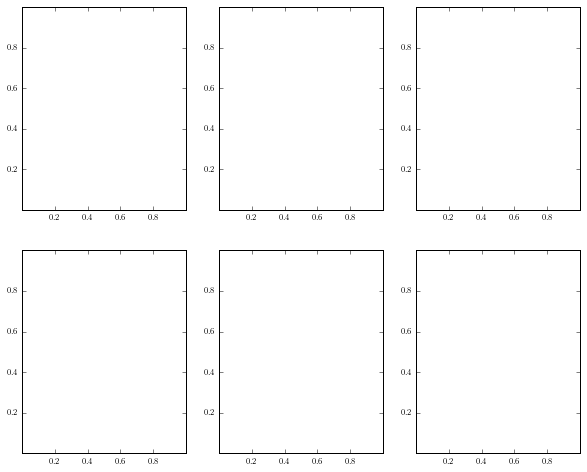

In [467]:
answers = questions['t11_arms_number']['answers']

fig,axarr = plt.subplots(2,3)
axarr = axarr.ravel()

for j,a in enumerate(answers):

    vf_deb,i = debias_all_data(spirals,answer=a)

    ax = axarr[j]
    
    ax.scatter(vf,vf_deb,c=np.log10(z),cmap=plt.cm.coolwarm,s=30,lw=0,alpha=1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

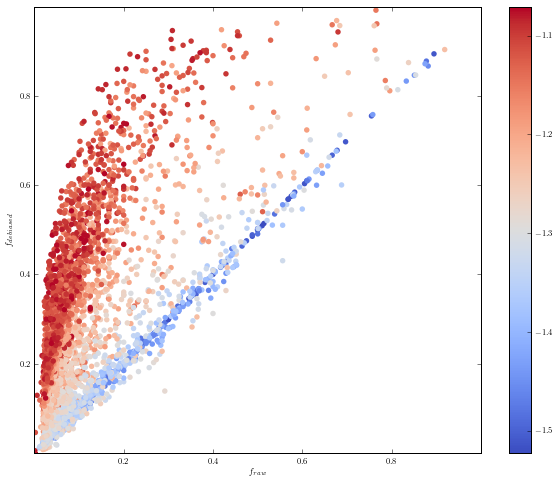

In [440]:


plt.xlabel('$f_{raw}$')
plt.ylabel('$f_{debiased}$')

plt.colorbar()

In [417]:
vf_original = spirals['t11_arms_number_a36_more_than_4_debiased_rh']

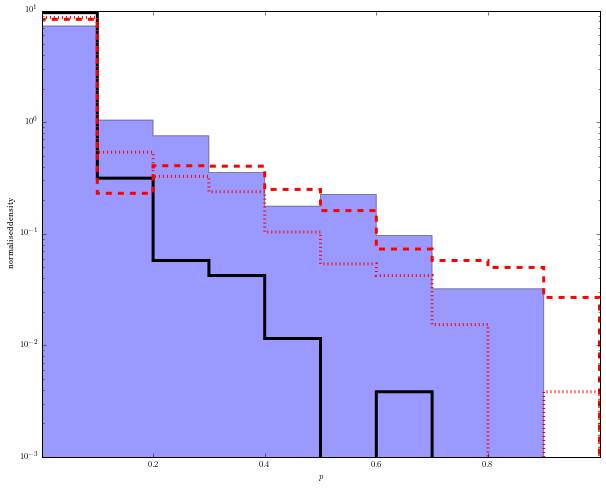

In [419]:
hist_bins = np.linspace(0,1,11)

low_z = spirals[(z <= 0.035)]
high_z = spirals[(z > 0.08)]

_ = plt.hist(low_z['t11_arms_number_a36_more_than_4_weighted_fraction'],bins=hist_bins,
             histtype='stepfilled',color='b',alpha=0.4,normed=True)

plt.yscale('log')

_ = plt.hist(high_z['t11_arms_number_a36_more_than_4_weighted_fraction'],bins=hist_bins,
             histtype='step',color='k',normed=True,linewidth=3)

_ = plt.hist(vf_original[(z > 0.08)],bins=hist_bins,
             histtype='step',color='r',normed=True,linewidth=3,linestyle='dotted')

_ = plt.hist(vf_deb[(z > 0.08)],bins=hist_bins,
             histtype='step',color='r',normed=True,linewidth=3,linestyle='dashed')

plt.xlabel('$p$')
plt.ylabel('normalised density')